sql engine ready
Mean Squared Error: 8.835408256683314


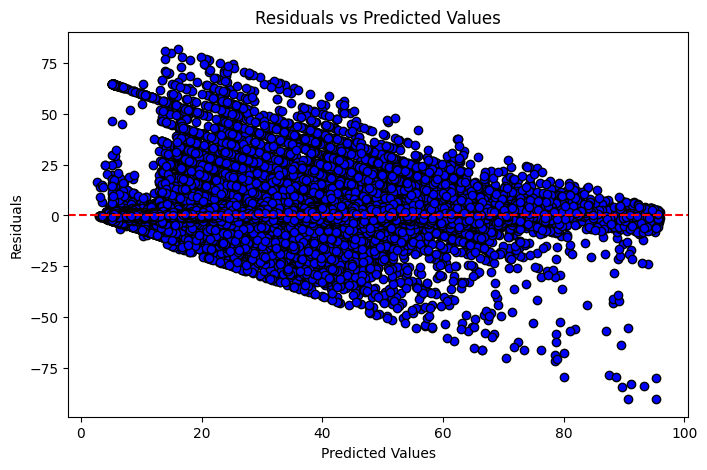

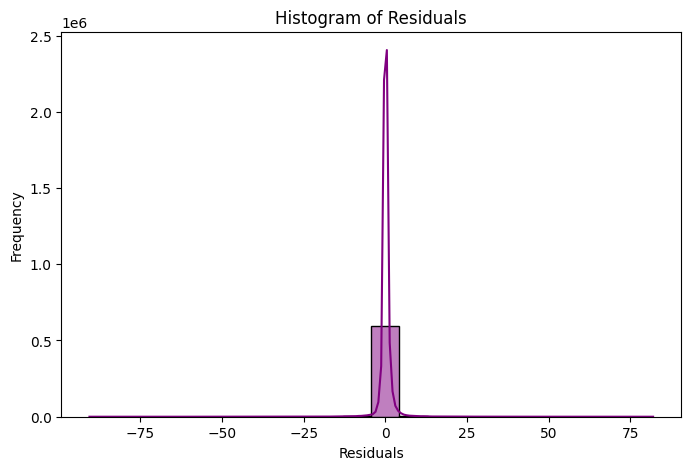

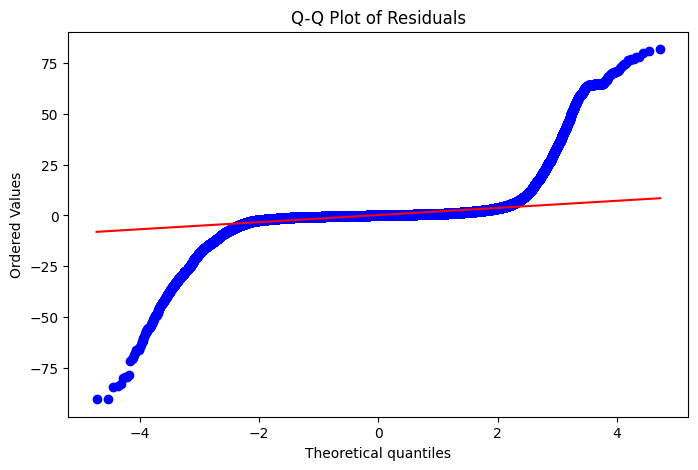

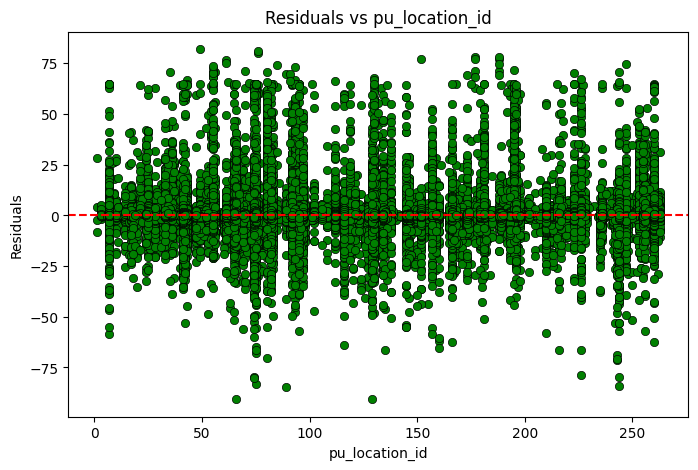

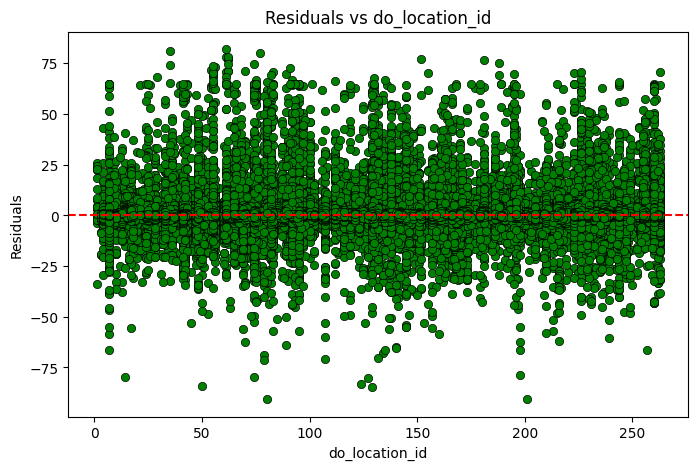

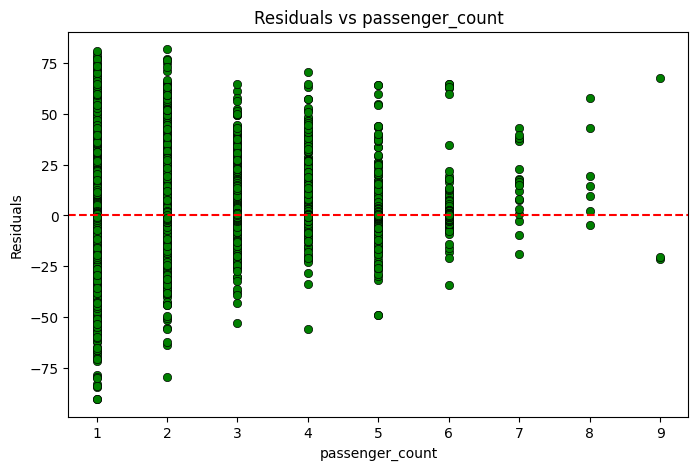

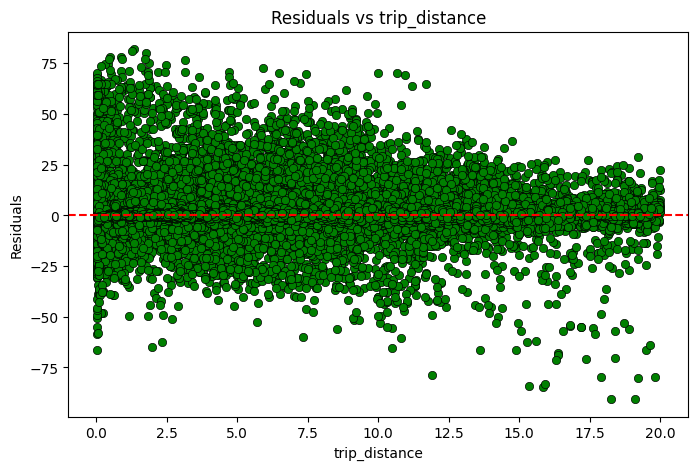

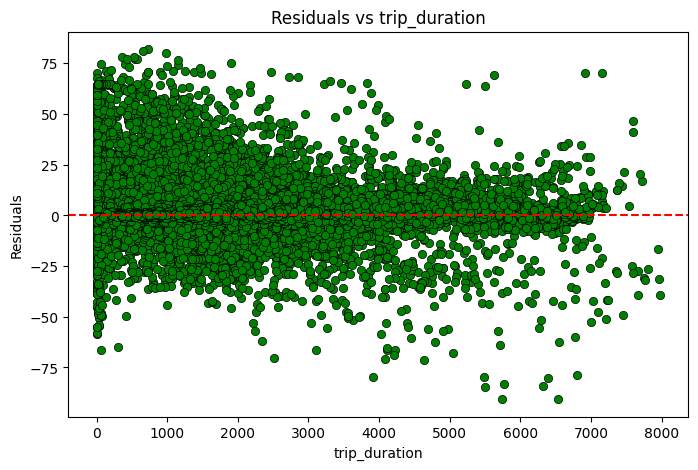

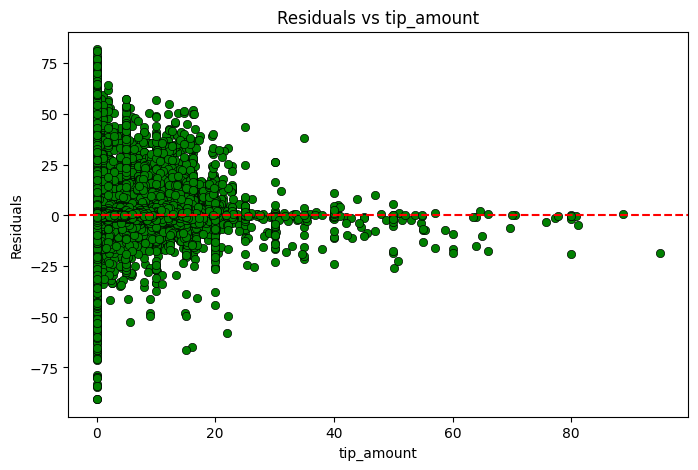

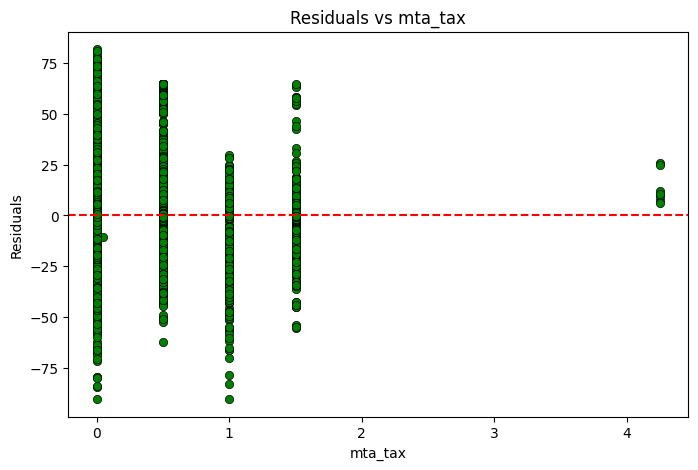

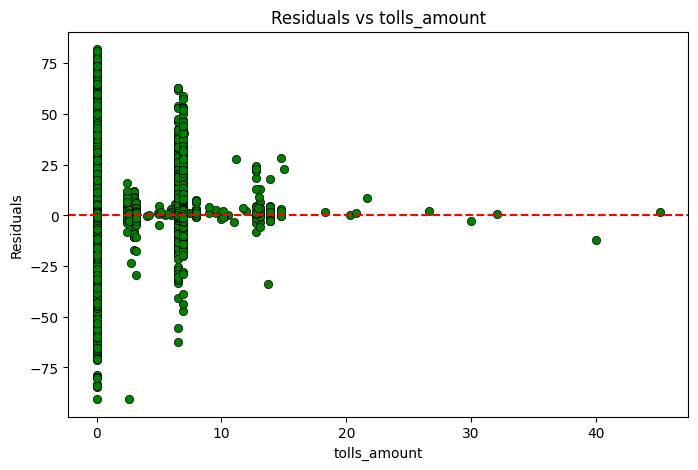

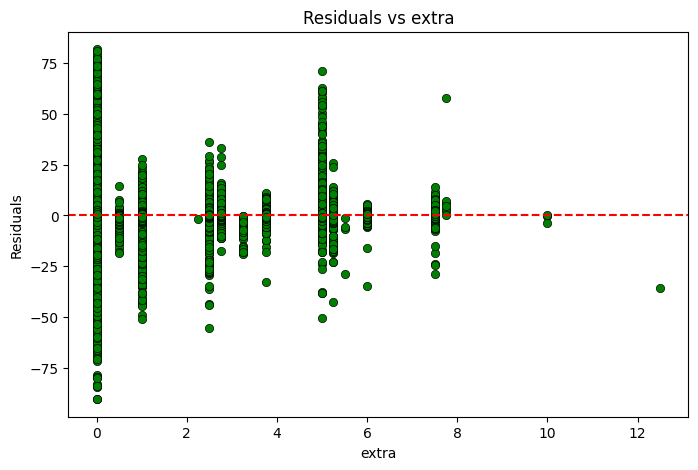

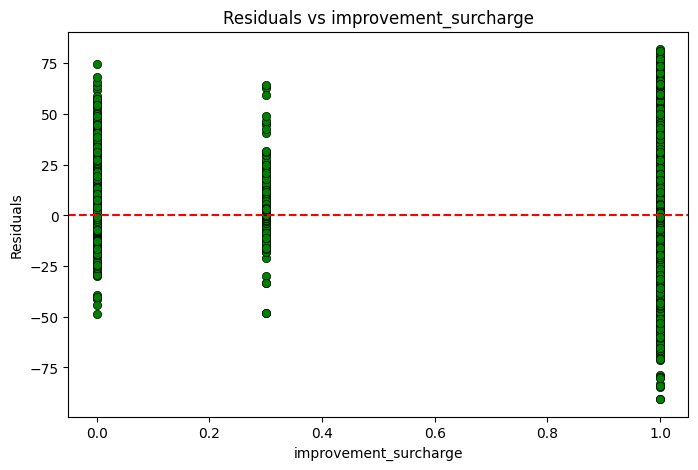

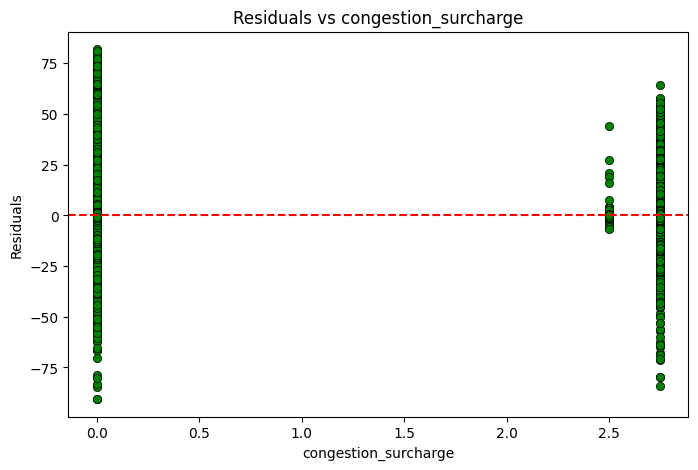

In [1]:
# Residual Analysis
from sklearn.linear_model import LinearRegression
from data import *
from model import *

taxi_type = GREEN
# train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = loadModel(f'{taxi_type}_{VARIABLE}_{RANDOM_FOREST}')

# Predictions
with DR.engn.connect() as conn:
    processed = 0
    y_t_chunk = []
    y_p_chunk = []
    X_t_chunk = []
    for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        X_t_chunk.append(X)
        y_t_chunk.append(df[VARIABLE])

        y_p_chunk.append(model.predict(X))
        O.out(f'Predicted {processed} rows')

# Performance
X_test = pd.concat(X_t_chunk, ignore_index=True)
y_test = pd.concat(y_t_chunk, ignore_index=True)
y_pred = np.concatenate(y_p_chunk)


residualAnalysis(X_test, y_test, y_pred)

In [1]:
# feature importance
from sklearn.ensemble import RandomForestRegressor
from data import *
from model import *

taxi_type = GREEN
train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = RandomForestRegressor(n_estimators=100, 
                              max_depth=10,
                              n_jobs=-1)

# FEATURES = ['pu_location_id', 'do_location_id', 'passenger_count', 'trip_distance', 
#             'trip_duration', 'tip_amount', 'mta_tax', 'tolls_amount', 'extra', 
#             'improvement_surcharge', 'congestion_surcharge']

# Training
with DR.engn.connect() as conn:
    processed = 0
    for df in pd.read_sql(train_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y = df[VARIABLE]

        model.fit(X, y)
        O.out(f'Trained {processed} rows')

importance = model.feature_importances_
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": importance}).sort_values(by="Importance", ascending=False)
print(feature_importance)


sql engine ready
                  Feature  Importance
3           trip_distance    0.777667
4           trip_duration    0.110217
6                 mta_tax    0.047483
9   improvement_surcharge    0.030341
5              tip_amount    0.021130
0          pu_location_id    0.004123
1          do_location_id    0.002492
2         passenger_count    0.002350
10   congestion_surcharge    0.002326
8                   extra    0.001311
7            tolls_amount    0.000560


In [1]:
from sklearn.ensemble import RandomForestRegressor
from data import *
from model import *

taxi_type = GREEN
train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = RandomForestRegressor(n_estimators=100, 
                              max_depth=10)

# Training
with DR.engn.connect() as conn:
    processed = 0
    for df in pd.read_sql(train_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y = df[VARIABLE]

        model.fit(X, y)
        O.out(f'Trained {processed} rows')

storeModel(model, f'{taxi_type}_{VARIABLE}_{RANDOM_FOREST}')

# Predictions
with DR.engn.connect() as conn:
    processed = 0
    y_test = []
    y_pred = []
    for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y_test.append(df[VARIABLE])

        y_pred.append(model.predict(X))
        O.out(f'Predicted {processed} rows')

# Performance
merged_y_test = pd.concat(y_test, ignore_index=True)
merged_y_pred = np.concatenate(y_pred)

showPerformance(merged_y_test, merged_y_pred)

sql engine ready
Model Accuracy Metrics:
Mean Absolute Error (MAE): 0.96
Root Mean Squared Error (RMSE): 2.97
R-squared (Accuracy): 0.93


In [1]:
from model import *

data = readData(taxi_type=GREEN)

sql engine ready
1675331
1011017
802356
757206


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = data[FEATURES_SET1]
y = data[VARIABLE]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient Boosting Model
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import plotly.graph_objects as go

# Calculate Model Accuracy Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Accuracy Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (Accuracy): {r2:.2f}")

# Limit data to 150 samples for visualization
samples_to_plot = 150
y_test_limited = y_test[:samples_to_plot].reset_index(drop=True)
y_pred_limited = y_pred[:samples_to_plot]

# Create Line Chart with Plotly
fig = go.Figure()

# Actual Values
fig.add_trace(go.Scatter(
    x=y_test_limited.index, 
    y=y_test_limited, 
    mode="lines+markers", 
    name="Actual",
    line=dict(color="blue")
))

# Predicted Values
fig.add_trace(go.Scatter(
    x=y_test_limited.index, 
    y=y_pred_limited, 
    mode="lines+markers", 
    name="Predicted",
    line=dict(color="orange")
))

# Customize Layout
fig.update_layout(
    title="Actual vs Predicted Fare Amount (Limited to 150 Samples)",
    xaxis_title="Sample Index",
    yaxis_title="Fare Amount ($)",
    legend=dict(x=0.5, y=1.15, xanchor="center", yanchor="top"),
    template="plotly_white"
)

# Show the plot
fig.show()


Model Accuracy Metrics:
Mean Absolute Error (MAE): 1.94
Root Mean Squared Error (RMSE): 4.22
R-squared (Accuracy): 0.88
